# Diffusion model


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import ssl
import certifi
import urllib.request

#### Load Mnist dataset

In [72]:
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context)))

# Define a transform to normalize the images to [0, 1].
transform = transforms.Compose([ transforms.ToTensor() ])

# Load the MNIST dataset.
mnist = MNIST(root='.', train=True, download=True, transform=transform)

x0, label = mnist[0] # First image in the dataset
x0 = x0.unsqueeze(0) # Add a batch dimension: [1, 1, 28, 28]


#### Markov Chain 


In [79]:
time_steps = 100

# Calculate the beta values for each step. Beta is the amount of noise added for each step.
def get_beta_schedule(step_size, start_value=0.0001, end_value=0.02):
  return torch.linspace(start_value, end_value, step_size)

betas = get_beta_schedule(time_steps)

# Find alpha values and cumulative product of alphas.
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)  # alpha_bar_t at each timestep

# Add noise to image x0 at time step t. 
def add_noise(x0, t):
  # Cumulative noise level for time step t.
  alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)
  
  # Generate random Gaussian noise.
  noise = torch.randn_like(x0)
  
  x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

  return x_t, noise
  



#### Test add noise to an image with a Markov chain.

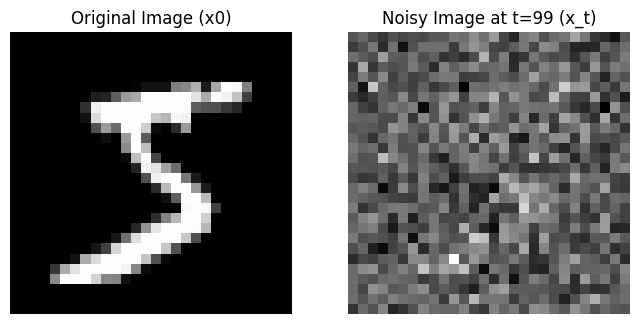

In [80]:
x_t_, noise_ = add_noise(x0, t=torch.tensor([time_steps-1]))

# Convert tensors to numpy for plotting
x0_np = x0.squeeze().numpy()  # Original image
x_t_np = x_t_.squeeze().detach().numpy()  # Noisy image

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image (x0)")
plt.imshow(x0_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Noisy Image at t={time_steps-1} (x_t)")
plt.imshow(x_t_np, cmap='gray')
plt.axis('off')

plt.show()

#### U-Net Architecture 

In [81]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    self.max_pool = nn.MaxPool2d(2, 2)

    # Contracting path: Decrease image dimensions while capturing relevant features.
    self.encoder1 = double_conv_relu(1, 64)
    self.encoder2 = double_conv_relu(64, 128)

    # The crossing between contracting and expanding.
    self.bottleneck = double_conv_relu(128, 256)

    # Expanding path: Reconstruct the output image using the most relevant features from the Contracting path.
    self.up_convolution_1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.up_convolution_2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

    self.decoder1 = double_conv_relu(256, 128)
    self.decoder2 = double_conv_relu(128, 64)

    # Output
    self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

  def forward(self, image):

    # Each block consists of two convolutions and two ReLu layers.
    # Between each block, pooling is used to reduce the size of the feature map.
    enc1_out = self.encoder1(image) # Output is passed on the corresponding block in the Expanding path.
    pool_enc1_out = self.max_pool(enc1_out)

    enc2_out = self.encoder2(pool_enc1_out) # Encoder dlock 2 output -> Decoder block 1
    pool_enc2_out = self.max_pool(enc2_out)

    bottle_out = self.bottleneck(pool_enc2_out)

    # Each block consists of two convolutions and two ReLu layers.
    # Between each block, transposed convolution (up-conv) is used to increase the size of the spatial size.
    up_conv_1_out = self.up_convolution_1(bottle_out)
    crop_up_conv_1_out = crop_tensor(enc2_out, up_conv_1_out)
    dec1_out = self.decoder1(torch.cat([up_conv_1_out, crop_up_conv_1_out], dim=1))

    up_conv_2_out = self.up_convolution_2(dec1_out)
    crop_up_conv_2_out = crop_tensor(enc1_out, up_conv_2_out)
    dec2_out = self.decoder2(torch.cat([up_conv_2_out, crop_up_conv_2_out], dim=1))

    return self.output_layer(dec2_out)

# Double convolution with ReLU
def double_conv_relu(in_channels, out_channels):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
  )

# Make the tensor the same size as the target tensor by cropping.
def crop_tensor(tensor, target_tensor):
  target_size = target_tensor.size()[2]
  tensor_size = tensor.size()[2]
  delta = (tensor_size - target_size) // 2
  return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]


#### Training Loop